In [1]:
# Dependencies.
# Data.
import pandas as pd
import numpy as np

# Data Viz.
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Database.
import sqlalchemy
from sqlalchemy import create_engine, text, inspect

# ORM Dependencies.
from sqlalchemy import Column, Integer, select, String, Float
from sqlalchemy.orm import Session, declarative_base
from sqlalchemy.ext.automap import automap_base

# Other.
import json
from pprint import pprint

In [2]:
# Database information for connection.
SQL_USERNAME = "postgres"
SQL_PASSWORD = "postgres"
SQL_IP = "localhost"
PORT = 5432
DATABASE = "crowdfunding"

In [3]:
# Connection to Database.
connection_string = f"postgresql+psycopg2://{SQL_USERNAME}:{SQL_PASSWORD}@{SQL_IP}:{PORT}/{DATABASE}"
engine = create_engine(connection_string)

In [4]:
# Inspect the Database.
inspector = inspect(engine)

# Get names of all tables in Database.
tables = inspector.get_table_names()

# Print the column names of each table and their type.
for table in tables:
    print(table)
    columns = inspector.get_columns(table)
    for column in columns:
        print(column["name"], column["type"])
        
    print()

contacts_df
contact_id INTEGER
first_name VARCHAR(250)
last_name VARCHAR(250)
email VARCHAR(250)

campaign_df
cf_id INTEGER
contact_id INTEGER
company_name VARCHAR(250)
description VARCHAR(250)
goal DOUBLE PRECISION
pledged DOUBLE PRECISION
outcome VARCHAR(250)
backers_count INTEGER
country VARCHAR(250)
currency VARCHAR(10)
launch_date TIMESTAMP
end_date TIMESTAMP
category_id VARCHAR(50)
subcategory_id VARCHAR(250)

category_df
category_id VARCHAR(50)
category VARCHAR(250)

subcategory_df
subcategory_id VARCHAR(50)
subcategory VARCHAR(250)



In [5]:
# Create a base class.
Base = automap_base()

# Reflect the tables.
Base.prepare(autoload_with=engine)

In [6]:
# Save references to the tables.
Contacts = Base.classes.contacts_df
Campaign = Base.classes.campaign_df
Category = Base.classes.category_df
Subcategory = Base.classes.subcategory_df

In [7]:
# Create a Session.
session = Session(bind = engine)

In [8]:
# Grab the Campaign outcome, goal, and pledged from the database.
# BUT: only the 'successful' or 'failed' campaigns from the US using USD as their currency.
results = session.query(
    Campaign.outcome,
    Campaign.goal,
    Campaign.pledged
).filter(
    (Campaign.outcome == "successful") | (Campaign.outcome == "failed"),
    Campaign.currency == "USD",
    Campaign.country == "US"
).all()

In [9]:
# Convert the data into a DataFrame.
campaign_df = pd.DataFrame(results)
display(campaign_df.info())
display(campaign_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 710 entries, 0 to 709
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   outcome  710 non-null    object 
 1   goal     710 non-null    float64
 2   pledged  710 non-null    float64
dtypes: float64(2), object(1)
memory usage: 16.8+ KB


None

,outcome,goal,pledged
0,successful,1800.0,7991.0
1,successful,1300.0,12047.0
2,failed,142400.0,21307.0
3,successful,3300.0,12437.0
4,failed,7200.0,6927.0


C:\Users\emteb\anaconda3\envs\dev\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


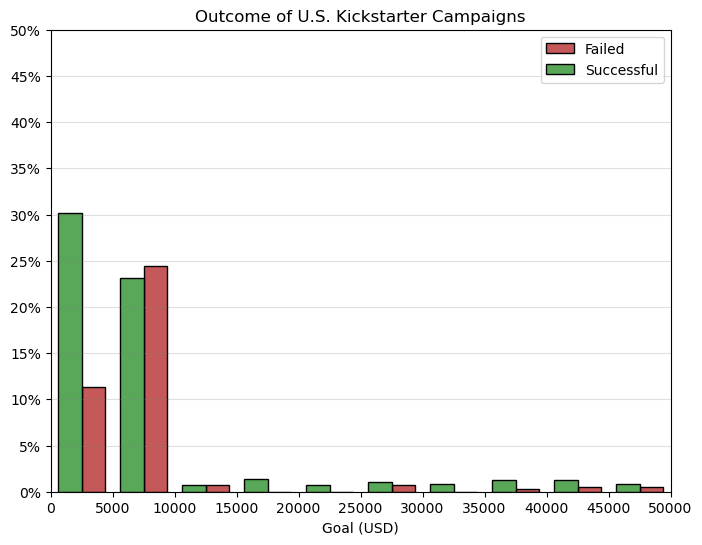

In [10]:
# Make a visualization.
# Canvas.
fig = plt.figure(figsize = (8, 6))

# Skeleton.
ax = sns.histplot(
    data = campaign_df,
    x = campaign_df.goal,
    stat = "percent",
    multiple = "dodge",
    shrink = .75,
    binwidth = 5000,
    binrange = (0, 50000),
    hue = campaign_df.outcome,
    palette = ["forestgreen", "firebrick"]
)

# Formatting.
plt.title("Outcome of U.S. Kickstarter Campaigns")

plt.xlabel("Goal (USD)")
plt.xticks(np.arange(0, 50001, 5000))
plt.xlim(0, 50001)

plt.ylabel("")
plt.yticks(np.arange(0, 101, 5))
plt.ylim(0, 50)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

plt.legend(["Failed", "Successful"])

plt.grid(axis = "y", color = "gray", alpha = .25)

# Show.
plt.show()

In [11]:
# Kill the connection.
engine.dispose() 